In [3]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import matplotlib.pyplot as plt
from pyproj import Proj, CRS, Transformer
import segyio

import file_ext_search as fes

import asd
import trace_proc


class MySpec(object):
    def __init__(self):
        self.iline = 189  # default value for segyio
        self.xline = 193  # default value for segyio
        self.tracecount = 0
        self.samples = []  # sample times, a list
        self.ext_headers = 0
        self.format = 1  # 1 - IBM Float; 5 - 4-byte IEEE float
        self.endian = 'big'

idx_file2 = r'D:\aa_yandexcloud\MyProjects\InspectingP70Data\P70_data\SEB\PS3SLF_2021-09-17T110351Z_00047728.asd.acf.idx'
acf_file2 = r'D:\aa_yandexcloud\MyProjects\InspectingP70Data\P70_data\SEB\PS3SLF_2021-09-17T110351Z_00047728.asd.acf'


idx_file = r'D:\aa_yandexcloud\MyProjects\InspectingP70Data\P70_data\SEB\Prof2_abp56_Gd\PS3SLF_2024-07-07T174231Z_07793648.asd.acf.idx'
acf_file = r'D:\aa_yandexcloud\MyProjects\InspectingP70Data\P70_data\SEB\Prof2_abp56_Gd\PS3SLF_2024-07-07T174231Z_07793648.asd.acf'

idx_files_2 = [idx_file2, idx_file]

datapath = r'G:\ABP_48\Parasound\ABP48\ASD\SLF'
idx_files_list = fes.file_ext_search('.idx', datapath)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Searching *.idx files in directory:G:\ABP_48\Parasound\ABP48\ASD\SLF


# TESTING DECONVOLUTION

In [120]:
from asd import  ASDfile
from xml_classes import Sounding

for no, idx_path in enumerate(idx_files_2[1:2]):
    acf_path = idx_path[:-4]
    asd_obj_list = ASDfile.create_from_idx_file(idx_path)
    
    traces = []
    
    # Load acf file into the memory
    with open(acf_path, 'rb') as f1:
        buffer = f1.read()
    
    trace_num = 1
    
    obj: ASDfile
    for obj in asd_obj_list[0:1]:
        asd.parse_xml_header(obj, buffer)
        asd.parse_bin_header(obj, buffer)

        sounding: Sounding
        for sounding in obj.soundings[0:1]:
            try:
                trace = trace_proc.proc_trace(trace_num, coord_transf, sounding, obj, tracelen=tracelen, delay=delay)
                trace.acf = os.path.basename(acf_path)
                traces.append(trace)
                trace_num += 1
            
            except:
                pass

12206
3183
[-8.85100549e-002  3.76147879e-001 -9.24109633e-002 ...  1.35143306e+202
  3.45228217e+201 -1.42008867e+202]
8.287277058139534e-05


In [124]:
def plot_signal(signal, saple_times):
    plt.plot(signal, saple_times)
    plt.title("Linear Chirp, f(0)=6, f(10)=1")
    plt.xlabel('t (sec)')
    plt.show()
    
# PULSE DECON
pulse_len = sounding.pulse_len

sounding_tg: Sounding
for sounding_tg in asd_obj.soundings:
    if len(sounding_tg.tg_list) != 0:
        bottom_target = sounding_tg.tg_list[0]
    else:
        pass

tg_abstime = bottom_target.time
tg_time_rel2trg = bottom_target.dist
# pulse_start = tg_time_rel2trg - pulse_len/2
# pulse_end = tg_time_rel2trg + pulse_len/2

pulse_start = tg_time_rel2trg - pulse_len*2
pulse_end = tg_time_rel2trg + pulse_len*2


pulse_samples = np.arange(pulse_start,pulse_end+ampl_scan_interval,ampl_scan_interval)

orig_signal = complex.real
func_sig = interpolate.CubicSpline(sample_times, orig_signal, extrapolate=False)
impulse_responce = func_sig(pulse_samples)

recovered, remainder = signal.deconvolve(orig_signal, impulse_responce)
# print(len(orig_signal))

samp_start = sample_times[0]
samp_end = sample_times[-1]

samp_dt = (samp_end - samp_start)/(len(sample_times)-1)
new_samp_dt = (samp_end - samp_start)/(len(recovered)-1)

print(int(1/ampl_scan_interval))
t = np.linspace(0,pulse_len,int(1/ampl_scan_interval))

w = signal.chirp(t, f0=sounding.slf_freq,f1=sounding.slf_freq + sounding.freq_shift,t1=pulse_len,method='linear')

In [95]:
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt

In [175]:
# let the signal be box-like
signal = obj.soundings[0].data_array[:,0]

signal_real = obj.soundings[0].data_array[:,0]
signal_imag = obj.soundings[0].data_array[:,1]

signal_3 = signal_real +  signal_imag

complex_signal = trace_proc.complex_trace(signal_real, signal_imag)

# signal_fft = complex_signal.real + complex_signal.imag
signal_fft = np.fft.fft(complex_signal.real) + np.fft.fft(complex_signal.imag)
signal_new = np.fft.ifft(signal_fft)


ampl_scan_interval = obj.soundings[0].ampl_scan_interval
pulse_len = obj.soundings[0].pulse_len




# and use a gaussian filter
# the filter should be shorter than the signal
# the filter should be such that it's much bigger then zero everywhere
gauss = np.exp(-( (np.linspace(0,50)-25.)/float(12))**2 )
print (gauss.min())  # = 0.013 >> 0

t = np.linspace(0,pulse_len,100)

w = scipy.signal.chirp(t, f0=sounding.slf_freq,f1=sounding.slf_freq + sounding.freq_shift,t1=pulse_len,method='linear')**2+0.013
gauss = w
gauss = impulse_responce
print(gauss.min())
# calculate the convolution (np.convolve and scipy.signal.convolve identical)
# the keywordargument mode="same" ensures that the convolution spans the same
#   shape as the input array.
#filtered = scipy.signal.convolve(signal, gauss, mode='same') 
# filtered = np.convolve(signal, gauss, mode='same') 

deconv,  _ = scipy.signal.deconvolve( signal, gauss )
#the deconvolution has n = len(signal) - len(gauss) + 1 points
n = len(signal)-len(gauss)+1
# so we need to expand it by 

s = (len(signal)-n)/2


#on both sides.
deconv_res = np.zeros(len(signal))
deconv_res[int(np.ceil(s)):int(np.ceil(len(signal)-s))] = deconv
deconv = deconv_res

# now deconv contains the deconvolution 
# expanded to the original shape (filled with zeros) 

0.013032907448509346
-10619.18303362857


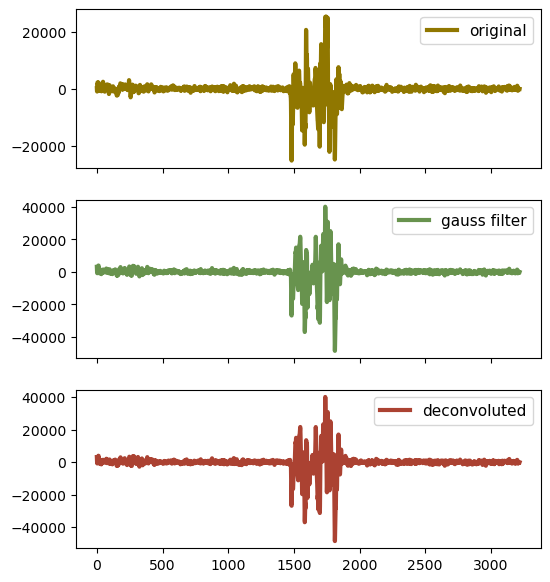

In [176]:
#### Plot #### 
fig , ax = plt.subplots(nrows=3, figsize=(6,7))

ax[0].plot(signal,            color="#907700", label="original",     lw=3 ) 
ax[1].plot(signal_new,          color="#68934e", label="gauss filter", lw=3 )

# we need to divide by the sum of the filter window to get the convolution normalized to 1
# ax[2].plot(filtered/np.sum(gauss), color="#325cab", label="convoluted" ,  lw=3 )
ax[2].plot(signal_3,         color="#ab4232", label="deconvoluted", lw=3 ) 

for i in range(len(ax)):

    ax[i].legend(loc=1, fontsize=11)
    if i != len(ax)-1 :
        ax[i].set_xticklabels([])

plt.show()    